In [1]:
from tpot import TPOTClassifier, TPOTRegressor
import dill
import pandas as pd

from configparser import ConfigParser
import numerapi
import os
import sys
if not os.getcwd().endswith('trading'): os.chdir('../../../../trading') # local machine
assert os.getcwd().endswith('trading'), 'Wrong path!'
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from collections import Counter
from skimpy import clean_columns

import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from pandarallel import pandarallel # parallel pandas
import time
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

import platform
from datetime import datetime
from sklearn.base import TransformerMixin
if platform.system() != 'Windows':
    mp.set_start_method('forkserver')
sys.path.append(os.getcwd())

In [3]:
model_dict = dill.load(open('/media/melgazar9/HDD_10TB/trading/objects/XGBRegressor_2022-03-17_16_28_00.pkl', 'rb'))

In [11]:
model_dict.keys()

dict_keys(['model', 'df_pred', 'feature_creator', 'feature_transformer', 'input_features', 'final_features', 'final_dtype_mapping', 'dropped_features', 'input_df'])

### train test split

In [18]:
TARGET = 'target_20d'
PRESERVE_VARS = ['XGBRegressor_pred', 'target_4d', 'yahoo_ticker', 'date_localized', 'dataset_split']
ID_VARS = ['date']

DROP_COLS = model_dict['dropped_features'] # [i for i in model_dict['df_pred'].columns if is_datetime(model_dict['df_pred'][i]) and i not in ID_VARS + PRESERVE_VARS]
OBJECT_COLS = [i for i in model_dict['df_pred'].columns if model_dict['df_pred'][i].dtype == 'object' and i not in ID_VARS + PRESERVE_VARS]

In [19]:
try:
    model_dict['df_pred'].set_index(ID_VARS, inplace=True)
except:
    pass
try:
    model_dict['df_pred'].drop(DROP_COLS, axis=1, inplace=True)
except:
    pass

In [20]:
X_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][model_dict['input_features']]
y_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][TARGET]

X_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][model_dict['input_features']]
y_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][TARGET]

X_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][model_dict['input_features']]
y_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][TARGET]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

KeyError: 'dataset_split'

In [ ]:
X_train.head()

In [9]:
X_train_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_train), columns=model_dict['final_features'])
X_val_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_val), columns=model_dict['final_features'])
X_test_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_test), columns=model_dict['final_features'])

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1, 4, 6, 7, 8, 9, 10, 11, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 40, 41, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1, 4, 6, 7, 8, 9, 10, 11, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 40, 41, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Original XGBRegressor score

In [10]:
print('\nTrain xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']))))



Train xgboost RMSE: 0.21775636044626057

Train xgboost RMSE: 0.21478515074959081

Train xgboost RMSE: 0.210123192139244



<AxesSubplot:ylabel='Frequency'>

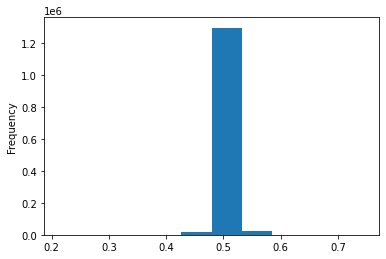

In [11]:
model_dict['df_pred']['XGBRegressor_pred'].plot(kind='hist')

### Train TPOT model

In [12]:
X_train_transformed.isnull().sum()[X_train_transformed.isnull().sum() > 0]

yahoo_ticker    936205
dtype: int64

In [13]:
y_train.isnull().sum()

0

In [17]:
X_train_transformed.drop('yahoo_ticker', axis=1, inplace=True)
X_val_transformed.drop('yahoo_ticker', axis=1, inplace=True)
X_test_transformed.drop('yahoo_ticker', axis=1, inplace=True)

In [18]:
X_train_transformed.isnull().sum()[X_train_transformed.isnull().sum() > 0]

Series([], dtype: int64)

In [19]:
X_train_transformed.dtypes.unique(), y_train.dtype

(array([dtype('float64')], dtype=object), dtype('float64'))

In [ ]:
tpot_model = TPOTRegressor(generations=2,
                           population_size=2,
#                            offspring_size=None,
                           mutation_rate=0.9,
#                            scoring='neg_mean_squared_error',
                           cv=3,
                           subsample=0.8,
                           n_jobs=16,
                           random_state=0,
                           use_dask=False,
                           early_stop=5,
                           config_dict='TPOT light')
tpot_model.fit(X_train_transformed, y_train)

In [ ]:
tpot_model.export('/media/melgazar9/HDD_10TB/trading/objects/tpot_exported_pipeline_{}.py'.format(str(datetime.today().date())))

### Below is slightly modified code generated by the exported tpot model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from tpot.export_utils import set_param_recursive

In [ ]:
imputer = SimpleImputer(strategy="median").fit(X_train_transformed.tail(100))

In [ ]:
X_train_transformed_tpot = imputer.transform(X_train_transformed.tail(100))
X_val_transformed_tpot = imputer.transform(X_val_transformed.tail(100))
X_test_transformed_tpot = imputer.transform(X_test_transformed.tail(100))

In [ ]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=0.01, loss="square", n_estimators=100)),
    XGBRegressor(learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.6500000000000001, verbosity=0)
)

In [ ]:
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)
exported_pipeline.fit(X_train_transformed_tpot, y_train.tail(100))

y_pred_train = exported_pipeline.predict(X_train_transformed_tpot)
y_pred_val = exported_pipeline.predict(X_val_transformed_tpot)
y_pred_test = exported_pipeline.predict(X_test_transformed_tpot)

### TPOT Metrics

In [ ]:
print('\nTrain xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']))))
